In [1]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import scipy.stats as stats

# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available data from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in high income countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
wetland = pd.read_csv('data/tidal_wetland_estuaries.csv')
wetland.head(5)

,name,coast,estu_latitude,estu_longintude,estu_dep,estu_perim,land_area,land_latitude,land_longitude,population,...,ocean_salinity_mean,air_temp_mean,frost_days_per_yr,ocean_sst_mean,ocean_diss_inorg_p,ocean_no3,tide_flow,mean_precip,mean_temp,soc_density
0,Florida Bay,GULF,25.039940,-80.731770,0.62000,614000.000,9.048954e+08,25.187310,-80.727540,3421,...,36.2,24.4,0.0,26.50,0.07,0.810,1.000000e+09,1251.831801,24.594719,0.087
1,South Ten Thousand Islands,GULF,25.311330,-81.057020,0.63000,597000.000,3.069216e+09,25.440250,-80.791070,235792,...,36.1,24.6,0.0,26.40,0.08,0.780,3.000000e+08,1355.907147,24.320596,0.000
2,North Ten Thousand Islands,GULF,25.724280,-81.377640,0.73000,906000.000,4.921106e+09,25.982520,-81.273680,9268,...,36.0,24.1,0.0,26.30,0.09,0.790,6.000000e+08,1416.239789,23.873671,0.084
3,Rookery Bay,GULF,25.998750,-81.756010,0.50000,148000.000,3.304589e+08,26.042920,-81.677710,14858,...,36.0,23.9,0.0,26.10,0.08,0.670,4.000000e+07,1432.519416,23.510000,0.086
4,Charlotte Harbor,GULF,26.754031,-82.103018,1.65938,507261.119,1.169284e+10,27.167615,-81.772154,597644,...,35.9,23.2,1.0,25.65,0.10,0.545,7.000000e+08,1320.275690,22.869199,0.073


##### A paired t-test is impossible, because EAST and WEST have difference sample sizes.

In [5]:
wetland_east = wetland[wetland['coast']=='EAST']
wetland_west = wetland[wetland['coast']=='WEST']
wetland_east['soc_density'].describe()['count'], wetland_west['soc_density'].describe()['count'] 

(52.0, 29.0)

##### A t-test assumes equal variances. This is a plausible assumption for EAST and WEST soc_density.

In [6]:
wetland_east['soc_density'].describe()['std'], wetland_west['soc_density'].describe()['std'] 

(0.02125968859071927, 0.018466918898291048)

##### Double-check that there is no missing data. (There is not.)

In [7]:
wetland_east['soc_density'].isna().sum(), wetland_west['soc_density'].isna().sum() 

(0, 0)

### Test the hypothesis that soil organic carbon density is larger in the East coast than the West coast with a t-test. Interpret the t-test.
##### Use the built-in t-test function, with the one-sided alternative hypothesis that EAST > WEST.

In [8]:
from scipy.stats import ttest_ind

ttest_ind(wetland_east['soc_density'],wetland_west['soc_density'], alternative='greater',equal_var=True) #p-value confirms mean(EAST) > mean(WEST)

Ttest_indResult(statistic=8.45031778669312, pvalue=5.765284478012742e-13)

##### The p-value is far less than 0.05, so we conclude that soc_density from EAST is larger than soc_density from WEST.

### Defend your choice of which type of t-test you used 

##### There are three types of t-test: 1-sample, 2-sample and paired-sample. Clearly, we have two samples (EAST and WEST) that we can assume are independent. (Organic carbon density along one coast does not tell us much about density on the other coast.) We cannot use the paired-sample test because the EAST and WEST samples are not of equal sizes (52 for EAST, 29 for WEST.)

### Do the data meet the requirement for normal data? Why or why not?
##### Normalize the data; for every observation ${x}$ define $x_{norm} = \frac{x-\mu}{\sigma}$

In [9]:
%matplotlib inline

import statsmodels.api as sm
from matplotlib import pyplot as plt

#normalize both density columns x_norm <- (x - mean(x))/std(x)
mu_east, sigma_east = wetland_east['soc_density'].mean(), wetland_east['soc_density'].std()
mu_west, sigma_west = wetland_west['soc_density'].mean(), wetland_west['soc_density'].std()

wetland_east_norm = wetland_east['soc_density'].apply(lambda x: (x - mu_east)/sigma_east)
wetland_west_norm = wetland_west['soc_density'].apply(lambda x: (x - mu_west)/sigma_west)

### A Q-Q plot of East/West density (normalized as z-scores) vs. quantities of the standard normal.

##### All points would lie very close to the 45-degree line if the Normality assumption is plausible.
##### East data: Except for one data point, normality is plausible.
##### West data: Points bow away from the line, and normality may be less plausible.

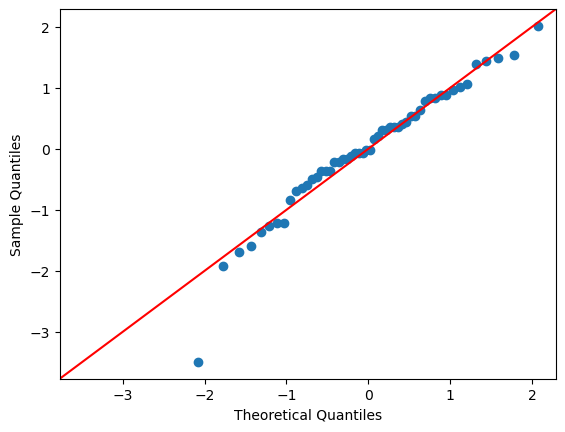

In [10]:
qq_plot_east = sm.qqplot(wetland_east_norm,line='45',fit=True)

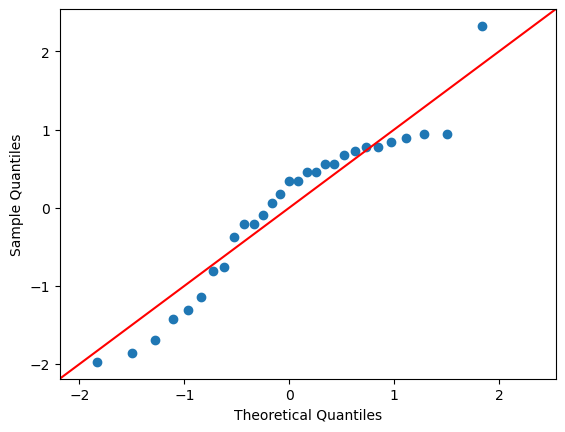

In [11]:
qq_plot_west = sm.qqplot(wetland_west_norm,line='45',fit=True)

###  The Kolmogorov-Smirnov Test
##### Yet, when asking questions about the data like "is it normally-distribution or not?", it is good practice to run several diagnostics. The QQ-plot is a visual diagnostic.
##### Next, run a statistical test for normality: Kolmogorov-Smirnov (K-S) test.

##### First, though, the 'cumulative distribution function' (c.d.f) of the data must be created, first. For any possible value ${x}$, the c.d.f is $P(X \le x)$. 

##### For  the density measurements, write a function to construct the c.d.f. The c.d.f we wish to compare it to -- the c.d.f of a standard normal distribution -- Python can do for us.

In [12]:
'''Takes a *sorted* sample and computes the proportion of values that are at most the reference value (x)'''
def cdf(sample, x):

    # Counts how many observations are below x. 'sample' is a list, and so samples <=x returns a list of True/False
    # answers, one per value in the sample. Since T/F are 1/0, the sum is a count.
    cdf = sum(sample <= x) 
    # Divides by the total number of observations
    cdf = cdf / len(sample)
    return cdf

def ks_norm(sample):
    # Sorts the sample
    sample.sort() #Must sort the sample before finding its cdf
    # Evaluates the KS statistic
    D_ks = [] # KS Statistic list
    for x in sample:
        cdf_normal = stats.norm.cdf(x = x, loc = 0, scale = 1) #Python can do the cdf for the standard normal
        cdf_sample = cdf(sample = sample, x = x) #We need to build the cdf for the sample of data
        D_ks.append(abs(cdf_normal - cdf_sample))
    ks_stat = max(D_ks) #The K-S test statistic is the largest gap between the two cdf curves
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    p_value = stats.kstwo.sf(ks_stat, len(sample))
    return {"ks_stat": ks_stat, "p_value" : p_value}

##### The K-S test NULL hypothesis is that the data *are* normally distributed. The p-values for both EAST and WEST exceed 0.05, so we cannot reject the NULL.
##### We can assume both EAST and WEST samples satisfy the normality assumption.

In [13]:
sample = wetland_east_norm.values
ks_norm(sample)

{'ks_stat': 0.0594144709730528, 'p_value': 0.98778324240631}

In [14]:
sample = wetland_west_norm.values
ks_norm(sample)

{'ks_stat': 0.14124528469854336, 'p_value': 0.5615310586491201}

## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

In [15]:
from utils import Linear_Reg_Diagnostic # do not change!

In [16]:
wetland.columns

Index(['name', 'coast', 'estu_latitude', 'estu_longintude', 'estu_dep',
       'estu_perim', 'land_area', 'land_latitude', 'land_longitude',
       'population', 'tide_ht', 'estu_salinity', 'ocean_salinity_mean',
       'air_temp_mean', 'frost_days_per_yr', 'ocean_sst_mean',
       'ocean_diss_inorg_p', 'ocean_no3', 'tide_flow', 'mean_precip',
       'mean_temp', 'soc_density'],
      dtype='object')

In [17]:
data = wetland[['coast','population','mean_temp','mean_precip','ocean_no3','estu_perim','estu_salinity','soc_density','ocean_salinity_mean']]
data.describe()
missing_yes_no = data[['mean_temp','mean_precip','ocean_no3','population']].apply(lambda x: x == -9999)
#missing_yes_no

### There is only one row in the data set with missing values.

In [18]:
data[(data['ocean_no3']==-9999) | (data['population']==-9999)]

,coast,population,mean_temp,mean_precip,ocean_no3,estu_perim,estu_salinity,soc_density,ocean_salinity_mean
33,GULF,-9999,23.597359,576.212644,-9999.0,-9999.0,-9999.0,0.006,-9999.0


In [19]:
wetland[(wetland['ocean_no3']==-9999) | (wetland['population']==-9999)][['land_latitude','land_longitude','estu_latitude','estu_longintude']]

,land_latitude,land_longitude,estu_latitude,estu_longintude
33,-9999.0,-9999.0,-9999.0,-9999.0


#### Using the pandas .describe(), we can read the median values for non-missing data, and replace the one row of missing values with them.

In [20]:
data[(data['population']>-9999)].describe()

,population,mean_temp,mean_precip,ocean_no3,estu_perim,estu_salinity,soc_density,ocean_salinity_mean
count,1.140000e+02,114.000000,114.000000,114.000000,1.140000e+02,114.000000,114.000000,114.000000
mean,1.790981e+06,15.271394,1329.269515,1.525918,5.807033e+05,21.117454,0.060518,33.411111
std,7.128520e+06,5.347184,459.341908,1.233919,8.665154e+05,7.591827,0.028121,1.635667
min,1.960000e+02,5.812948,296.848333,0.120000,1.400000e+04,1.000000,0.000000,30.300000
25%,2.618350e+04,10.384426,1183.762062,0.420000,1.507500e+05,15.250000,0.044000,32.100000
50%,2.218895e+05,16.349733,1251.812996,1.245000,3.815000e+05,22.000000,0.063000,33.000000
75%,1.350630e+06,19.707794,1542.003156,2.003750,6.850000e+05,28.000000,0.083500,35.175000
max,7.300918e+07,24.594719,3004.912778,4.290000,8.074933e+06,29.000000,0.120000,36.300000


##### Use medians to replace missing values in the one row (33).

In [21]:
data.loc[33,['mean_temp','mean_precip','ocean_no3','population','estu_perim','estu_salinity','ocean_salinity_mean']] = [16.34973,1251.812996,1.245,2.2189e+05,3.815e+05,22.0,33.0]


#### It's a good idea to put all independent variables on a comparable scale to each other.

In [22]:
data['popn_1M'] = data['population'].apply(lambda x : x / 1E6)
data['estu_perim_1M'] = data['estu_perim'].apply(lambda x : x / 1E6)
data[['estu_perim_1M','popn_1M']].describe()
#sns.pairplot(data[['coast','mean_temp','mean_precip','ocean_no3','popn_10000']],hue='coast')

/var/folders/3b/ml9q645j7d9bj33sx3cqvm840000gn/T/ipykernel_5575/3125869038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['popn_1M'] = data['population'].apply(lambda x : x / 1E6)
/var/folders/3b/ml9q645j7d9bj33sx3cqvm840000gn/T/ipykernel_5575/3125869038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['estu_perim_1M'] = data['estu_perim'].apply(lambda x : x / 1E6)


,estu_perim_1M,popn_1M
count,115.000000,115.000000
mean,0.578971,1.777337
std,0.862906,7.098694
min,0.014000,0.000196
25%,0.151500,0.026420
50%,0.381500,0.221890
75%,0.676000,1.336687
max,8.074933,73.009176


### Draw a pair-plot of several independent variables and the dependent soc_density (last row, last column). 
##### Color-code the scatter plot and diagonal distribution (a variable plotted against itself) by the region (EAST,WEST,GULF). The legend is small, but on the right hand side.

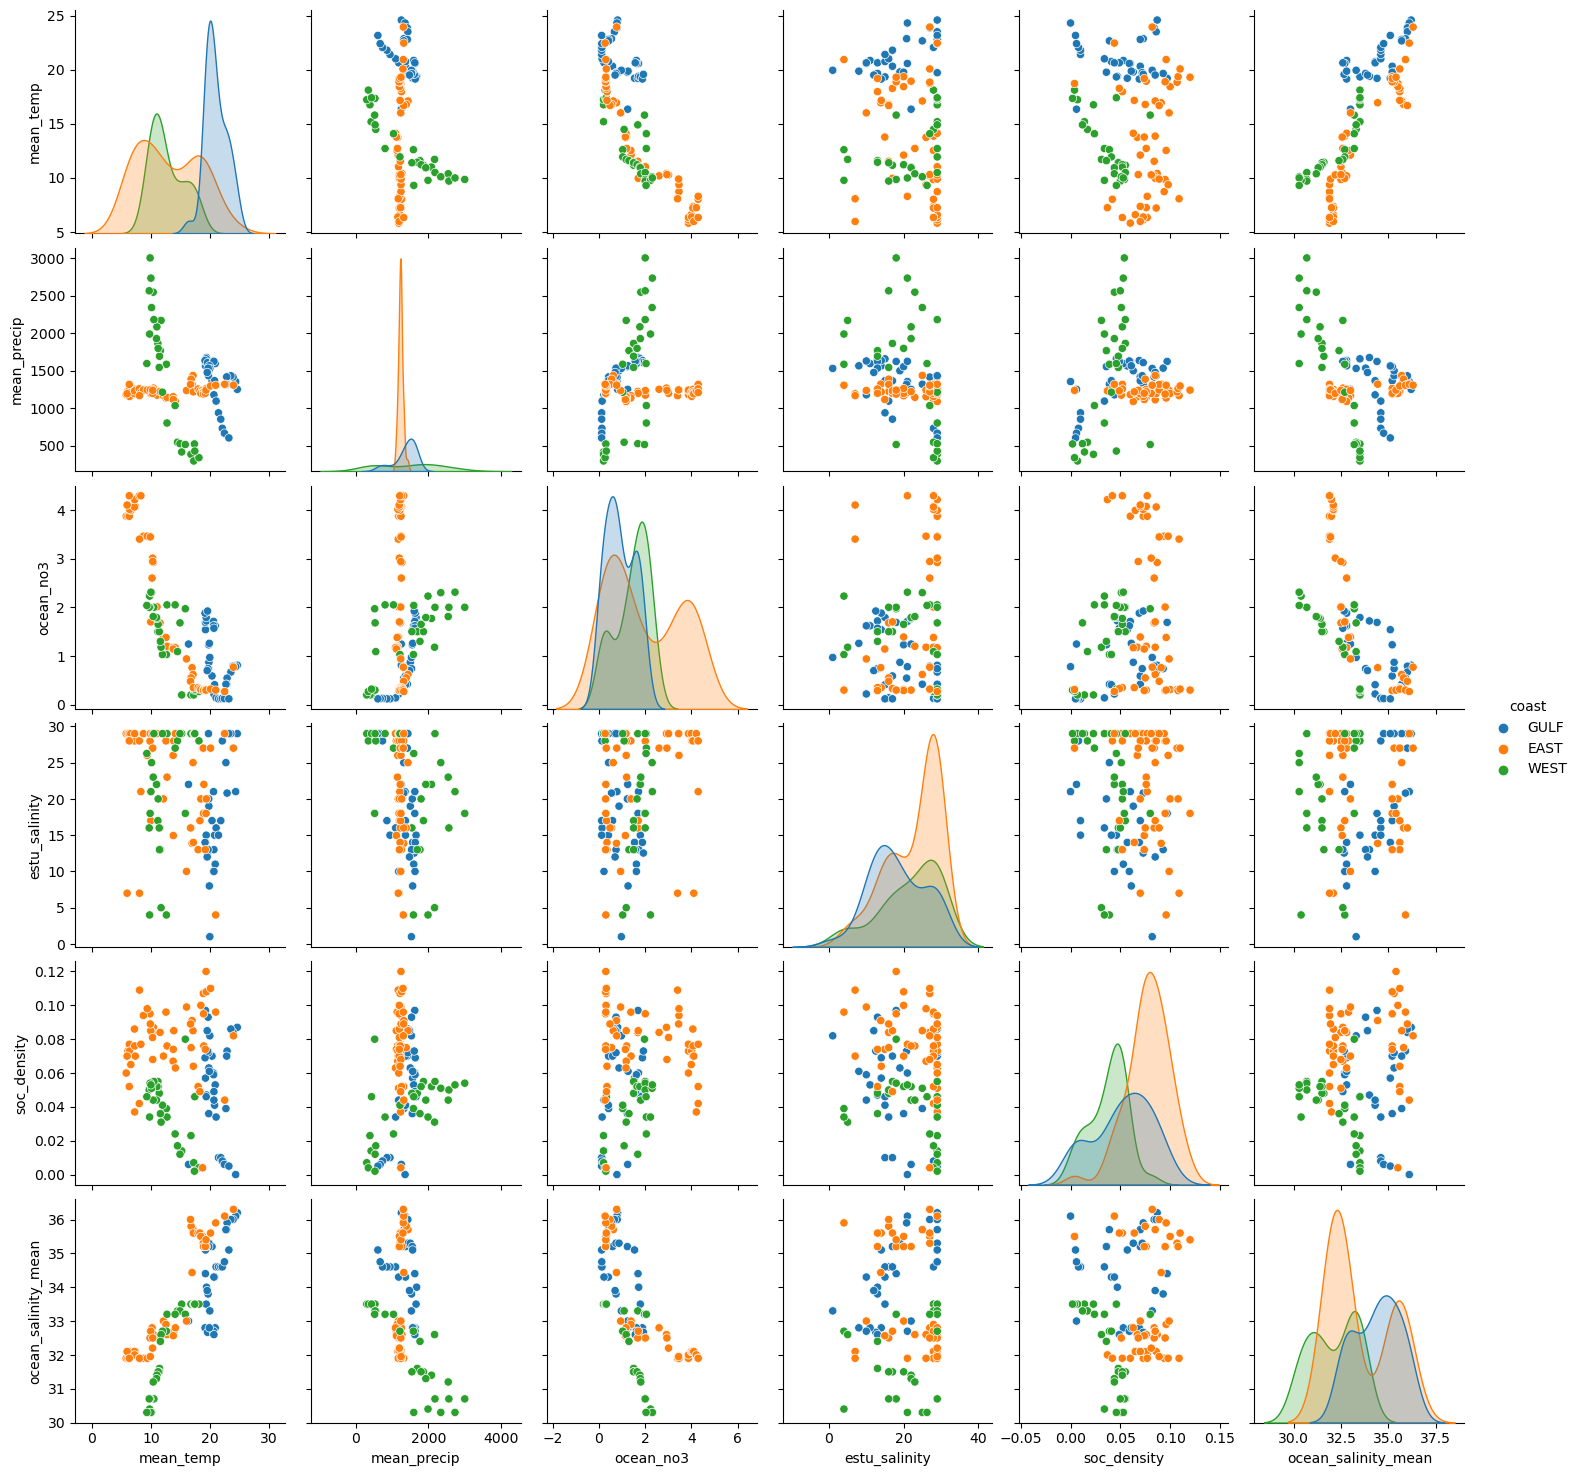

In [23]:
sns.pairplot(data[['coast','mean_temp','mean_precip','ocean_no3','estu_salinity','soc_density','ocean_salinity_mean']],hue='coast')

### Create a linear model to predict mean ocean salinity from other environmental factors

In [24]:
dummy = pd.get_dummies(data['coast'].values) 
temp = data[['mean_temp','mean_precip','ocean_no3','ocean_salinity_mean','soc_density']]
df = temp.merge(right=dummy,left_index=True,right_index=True)
y = df['ocean_salinity_mean']
X = df.loc[:,~df.columns.isin(['ocean_salinity_mean'])]
X = sm.add_constant(X,prepend=False)
X.shape, y.shape

((115, 8), (115,))

In [25]:
result = sm.OLS(y,X).fit()
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     ocean_salinity_mean   R-squared:                       0.830
Model:                             OLS   Adj. R-squared:                  0.820
Method:                  Least Squares   F-statistic:                     87.60
Date:                 Fri, 05 May 2023   Prob (F-statistic):           3.42e-39
Time:                         21:39:14   Log-Likelihood:                -117.05
No. Observations:                  115   AIC:                             248.1
Df Residuals:                      108   BIC:                             267.3
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
mean_temp       0.2763      0.037      7

### Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0.
##### The previous model does not satisfy these conditions

In [26]:
data = wetland[['coast','air_temp_mean','ocean_salinity_mean','mean_temp','mean_precip','ocean_sst_mean','ocean_diss_inorg_p','estu_salinity','soc_density']]
data.describe()

,air_temp_mean,ocean_salinity_mean,mean_temp,mean_precip,ocean_sst_mean,ocean_diss_inorg_p,estu_salinity,soc_density
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,-71.641173,-53.827246,15.343793,1322.721194,-69.582502,-86.591720,-66.014002,0.060043
std,933.867260,935.528577,5.379997,462.682843,934.066465,932.445073,934.411341,0.028455
min,-9999.000000,-9999.000000,5.812948,296.848333,-9999.000000,-9999.000000,-9999.000000,0.000000
25%,10.400000,32.100000,10.391126,1180.411409,12.075000,0.190000,15.000000,0.044000
50%,16.100000,33.000000,16.688636,1251.794191,16.733333,0.350000,22.000000,0.063000
75%,20.450000,35.150000,19.747514,1539.599161,23.750000,0.560000,28.000000,0.083000
max,24.600000,36.300000,24.594719,3004.912778,26.600000,0.630000,29.000000,0.120000


##### Use medians to replace missing values in the one row (33).

In [27]:
data.loc[33,['air_temp_mean','ocean_salinity_mean','mean_temp','mean_precip','ocean_sst_mean','ocean_diss_inorg_p','estu_salinity']] = \
                        [16.1,33.0,16.6886,1251.794,16.7333,0.350000,22.0]

In [28]:
import statsmodels.formula.api as smf

#dummy = pd.get_dummies(data['coast'].values) 
temp = data[['coast','ocean_diss_inorg_p','ocean_salinity_mean','air_temp_mean','mean_precip','estu_salinity','soc_density']]
df = temp.merge(right=dummy,left_index=True,right_index=True)
y = df['ocean_salinity_mean']
X = df.loc[:,~df.columns.isin(['ocean_salinity_mean'])]
result = smf.ols(formula='ocean_salinity_mean~ocean_diss_inorg_p:C(coast)',data=temp).fit()
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     ocean_salinity_mean   R-squared:                       0.865
Model:                             OLS   Adj. R-squared:                  0.861
Method:                  Least Squares   F-statistic:                     236.2
Date:                 Fri, 05 May 2023   Prob (F-statistic):           5.07e-48
Time:                         21:40:19   Log-Likelihood:                -103.82
No. Observations:                  115   AIC:                             215.6
Df Residuals:                      111   BIC:                             226.6
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

#### This model meets the conditions: R-squared > 0.80 and every coefficient has a VIF is below 5.0.
##### The model formula 'ocean_salinity_mean~ocean_diss_inorg_p:C(coast)' means  that ocean_salinity_mean is predicted by region-specific 'Ocean dissolved inorganic phosphorous' ...the model fits different coefficient for EAST, WEST and GULF observations of this variable.
##### The intercept VIF > 5.0, which is not concerning. This merely says the model's errors would be greatly altered by removing the overall mean as a predictor (which rarely makes sense).

In [29]:
cls = Linear_Reg_Diagnostic(result)
cls.vif_table()

                            Features  VIF Factor
3  ocean_diss_inorg_p:C(coast)[WEST]        2.21
2  ocean_diss_inorg_p:C(coast)[GULF]        2.23
1  ocean_diss_inorg_p:C(coast)[EAST]        2.48
0                          Intercept        7.89


### Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. 

##### The diagnostic plots are 'okay'. No points fall outside the 'Cook's Distance curves', which means none are overly influence to the model fit. It would be better if the red line in the Scale-Location was more horizontal.

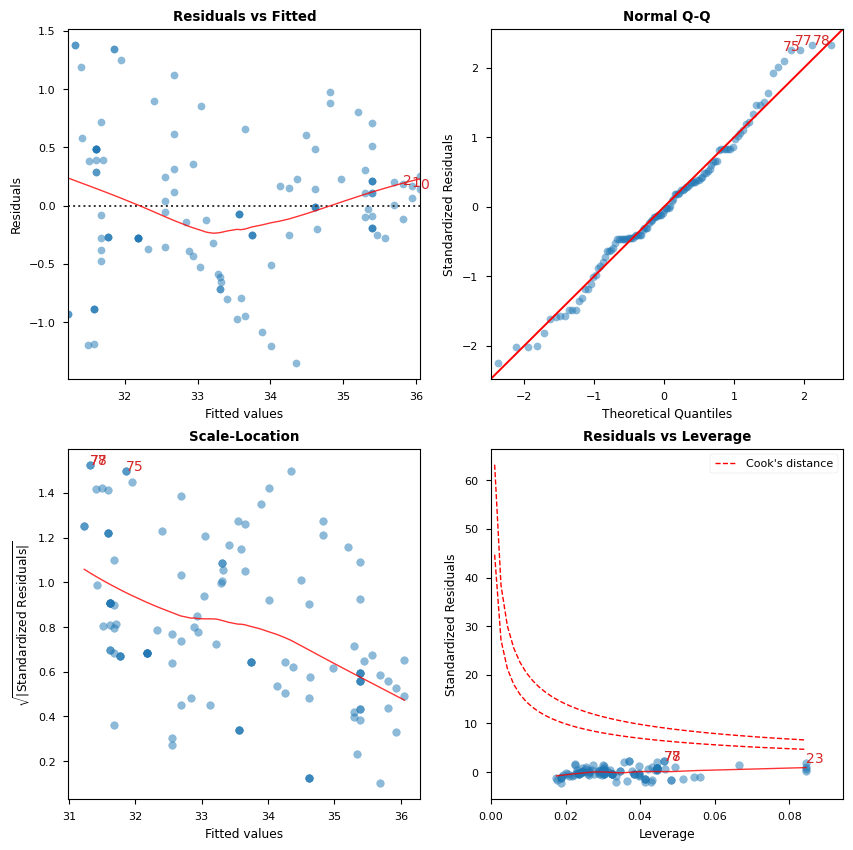

                            Features  VIF Factor
3  ocean_diss_inorg_p:C(coast)[WEST]        2.21
2  ocean_diss_inorg_p:C(coast)[GULF]        2.23
1  ocean_diss_inorg_p:C(coast)[EAST]        2.48
0                          Intercept        7.89
Figure(1000x1000)


In [30]:
vif, fig = cls()
print(vif)

## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)

### Process the data to be useable for time series analysis

In [32]:
%matplotlib inline
coal = pd.read_csv('data/coal-production.csv',index_col='year')
coal.head(5)

,electricity_prod
year,
1960,45.904345
1961,45.730794
1962,46.411172
1963,46.599523
1964,46.102588


### Display your data. Does it appear to have a trend? If so, describe the trend.

<AxesSubplot:xlabel='year'>

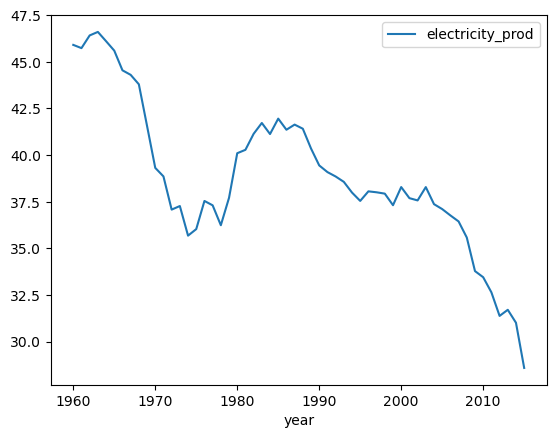

In [33]:
coal.plot()  #Except for the mid 1970's-mid 1980's, electricity production from coal is consistently on a downward trend.

### Test for stationarity.

##### The Augmented Dickey Fuller Test (ADF Test) confirms what the plot shows; the data is not stationary. (The time series does not fluctuate around a constant average value.)

In [34]:
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest

adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(coal['electricity_prod']) 
p_val, should_diff #The p-value > 0.05 --> differencing 'should' be applied.

(0.3695059122713751, True)

In [35]:
from pmdarima.arima.utils import ndiffs

#### The ADF Test tells us to 'difference', but how many times?
n_adf = ndiffs(coal['electricity_prod'], test='adf')  # -> 2

### Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. 
#### What type of ARIMA model was found to be the best fit? 

Text(0, 0.5, 'Electricity from Coal (% of total)')

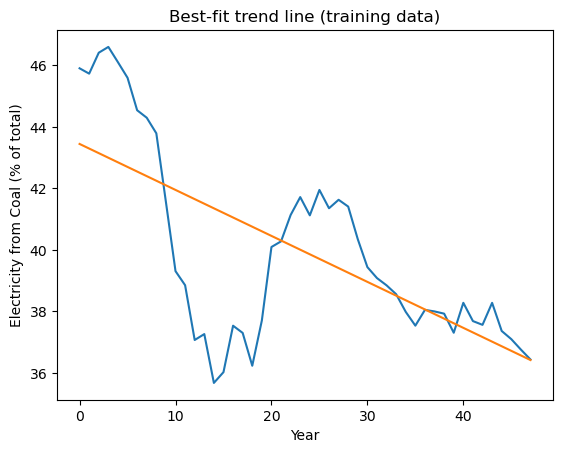

In [36]:
#### Set aside a portion of the data as a 'test' set. Only use it to evaluate, not create the model.
from pmdarima import model_selection
from sklearn.linear_model import LinearRegression

train, test = model_selection.train_test_split(coal['electricity_prod'], train_size=48) #set aside '8 years' for evaluation

# The trend needs to be eliminated for ARIMA. Do this by subtracting from the time series the best-fit regression line.
X = [i for i in range(0, len(train))]
X = np.reshape(X, (len(X), 1))
y = train.values
model = LinearRegression()
model.fit(X, y)
# The best-fit trend line.
trend = model.predict(X)

# Remove the trend; subtract the best-fit prediction from every observation.
detrended = [y[i]-trend[i] for i in range(0, len(train))]

# plot trend
x_axis = 1960 + np.arange(train.shape[0])
plt.plot(y)
plt.plot(trend)
plt.title('Best-fit trend line (training data)')
plt.xlabel('Year')
plt.ylabel('Electricity from Coal (% of total)')

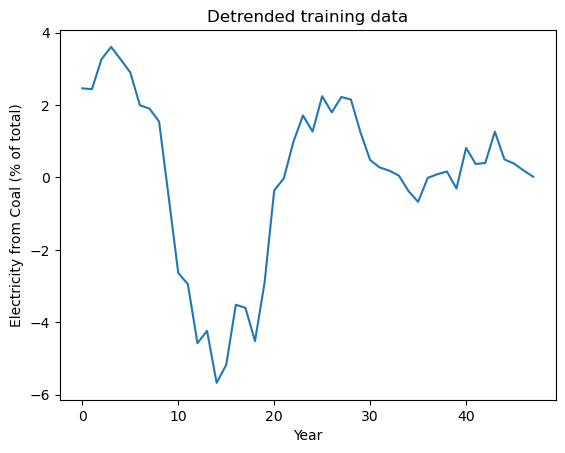

In [37]:
# This is the de-trended time series.
plt.plot(detrended)
plt.title('Detrended training data')
plt.xlabel('Year')
plt.ylabel('Electricity from Coal (% of total)')
plt.show()

#### Let auto-ARIMA choose the best model. 

In [38]:
stepwise_fit = pm.auto_arima(detrended, max_p=6, max_q=6, error_action='ignore', stepwise=False, trace=True, suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=10, step=4, h=4)
#est = pm.ARIMA(order=(2,2,1), suppress_warnings=True)
predictions = model_selection.cross_val_predict(stepwise_fit, detrended, cv=cv, verbose=2, averaging="median")

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=221.615, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=176.249, Time=0.07 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=157.852, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=146.126, Time=0.26 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=142.938, Time=0.18 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=137.069, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=130.516, Time=0.02 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=129.608, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=131.456, Time=0.16 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=129.419, Time=0.20 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=128.782, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=128.906, Time=0.04 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=129.578, Time=0.04 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(4,0,0)(0,0,0)[1] intercept   : AIC=123.648, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[1] intercept   : AIC=118.280, Time=0.15 sec
 ARIMA(5,0,0)(0,0,0)[1] intercept   : AIC=121.342, Time=0.05 sec

Best model:  ARIMA(4,0,1)(0,0,0)[1] intercept
Total fit time: 3.817 seconds
[CV] fold=0 ..........................................................


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................


### Describe the chosen model.
#### Auto-ARIMA chose an ARMA(4,0,1) model:  $\hat{y}_t = \theta_{t-1} y_{t-1}+\theta_{t-2} y_{t-2}+...+\theta_{t-4} y_{t-4}+\phi_{t-1}\epsilon_{t-1}$
#### In words, the forecast at time 't' is a linear combination of the most recent four observations {t-1,t-2,...,t-4} along with an adjustment
#### from the error from the last forecast at t-1.

In [39]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(4, 0, 1)   Log Likelihood                 -52.140
Date:                Fri, 05 May 2023   AIC                            118.280
Time:                        21:45:10   BIC                            131.378
Sample:                             0   HQIC                           123.230
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0280      0.044     -0.634      0.526      -0.115       0.059
ar.L1          1.5127      0.224      6.742      0.000       1.073       1.952
ar.L2         -0.6192      0.275     -2.250      0.024      -1.159      -0.080
ar.L3          0.3479      0.276      1.260      0.208      -0.193       0.889
ar.L4         -0.3565      0.205     -1.741      0.082      -0.758       0.045
ma.L1         -0.6604      0.183     -3.616      0.000      -1.018      -0.302
sigma2         0.4778      0.130      3.687      0.000       0.224       0.732
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 2.37
Prob(Q):                              0.81   Prob(JB):                         0.31
Heteroskedasticity (H):               0.43   Skew:                            -0.53
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Visualize the fitted values of the ARIMA model, being sure to label each line.

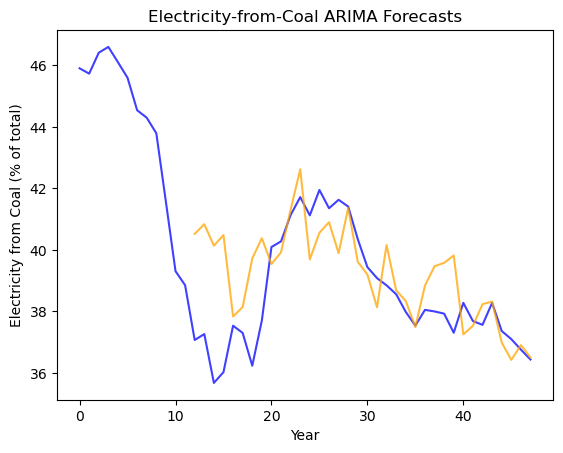

In [40]:
x_axis = np.arange(train.shape[0])
n_test = predictions.shape[0]

plt.plot(x_axis, train, alpha=0.75, c='b',label='actual')
plt.plot(x_axis[-n_test:], trend[-n_test:] + predictions, alpha=0.75, c='orange',label='predicted')  # Forecasts
plt.title("Electricity-from-Coal ARIMA Forecasts")
plt.xlabel('Year')
plt.ylabel('Electricity from Coal (% of total)')
plt.show()